# Header File and libraries

In [27]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [28]:
maxAcc = 0.0
maxIter = 0
C_Lambda =0.1#0.001,0.002,0.003,0.005,0.01,] #lambda(CHANGE) original is 0.03
TrainingPercent = 80  
ValidationPercent = 10
TestPercent = 10
M = 9#15,17,20,21,22,23,24,25,26,27,28,30]  #the number of basis function(CHANGE) original is 10,the number of features
PHI = []  #store design metrix
IsSynthetic = False

# Function Definition

In [29]:
def GetTargetVector(filePath):  #generate trainingdata
    t = []
    with open(filePath, 'rU') as f:  #import excel_t(target values)
        reader=csv.reader(f)  ###change csv to excel
        for row in reader:  
            t.append(int(row[1]))  #The first column of datasets represents target values
            ###I change row[2] to row[1]
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):  #import all corresponding features,such as for humandata,it has 18 features for every pair   
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)   ###change csv to excel
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :  #np.append:combine dataMatrix and []，axis is not defined，axis=0，add below，1 add right
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)  #delete subvector 0（entire row）1（entire column）couldn't delete element
    dataMatrix = np.transpose(dataMatrix)  #remove unrelevant datapoints   
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil((rawTraining.shape[0])*(TrainingPercent*0.01)))  #returns the number which is greater than or equals to parameter
    t           = rawTraining[:TrainingLen]  #
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil((rawData.shape[0])*0.01*TrainingPercent))
    d2 = rawData[0:T_len,:]  #
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount+1:V_End,:]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):###
    BigSigma    = np.zeros((len(Data),len(Data)))+0.2  #0 array
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):  #41 dimensions
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))  #np.var means calculate vct's varience
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]  #turn varvect to diagnol metrix,covariance matrix
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)  #multiply
    else:
        BigSigma = np.dot(1,BigSigma)  #(TA said:simultaneously remove this and w_now) or set 1,original is 200
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)  
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))  #exponential(Gaussian radial basis function)
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = c(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)  #(scalar)the inverse of sigma
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)  #we get equation (2)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):  #get equation (8)
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)  #lambda
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)  #inverse
    INTER       = np.dot(PHI_SQR_INV, PHI_T)  #tansform
    W           = np.dot(INTER, T)  
    ##print ("Training Weights Generated..")
    return W

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)  #Mumatrix means centroid C
    #print ("PHI Generated..")
    return PHI

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)  #square error
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1  #correct prediction and increment 
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

# Fetch and Prepare Dataset

In [30]:
#GetTargetVector GenerateRawData
RawTarget = np.array(pd.read_csv(r'C:\Users\Administrator\Desktop\concatenationtargets.csv').values) 
RawData   = np.array(pd.read_csv(r'C:\Users\Administrator\Desktop\Humansubtractfeatures.csv').values) 

# Prepare TR/VA/TE Data

In [31]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(1336, 1)
(1336, 9)
(166, 1)
(0, 9)
(166, 1)
(0, 9)


# Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]


In [32]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)  #design metrix
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) #(8)
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)
#print(Mu.shape)
#print(BigSigma.shape)
#print(TRAINING_PHI.shape)
#print(W.shape)
#print(VAL_PHI.shape)
#print(TEST_PHI.shape)
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)  #testingdate
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
# print ('UBITname      = De Guo')
# print ('Person Number = 50289395')
# print ('----------------------------------------------------')
# print ("------------------LeToR Data------------------------")
# print ('----------------------------------------------------')
# print ("-------Closed Form with Radial Basis Function-------")
# print ('----------------------------------------------------')
print ("M =  ","\nLambda = ")
print ("Training accuracy  = " + str(float(TrainingAccuracy.split(',')[0])))  #0,accuracy
print ("Validation accuracy= " + str(float(ValidationAccuracy.split(',')[0])))  
print ("Testing accuracy   = " + str(float(TestAccuracy.split(',')[0])))  

print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))  #1,error 
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))  
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))  
        

ValueError: operands could not be broadcast together with shapes (1669,) (1336,) 

# Stochastic Gradient Descent Solution for Linear Regression 

In [33]:
W_Now        = np.zeros(M)  #set 1,original is 220
La           = 0.1
learningRate = 0.005 #that can be changed,original one is 0.01 
   
L_Erms_Val   = []  #For each epoch we calculate t,v,t error
L_Erms_TR    = []
L_Erms_Test  = []  #we can do testing after training is done
W_Mat        = []

for i in range(0,1266):  #SGD
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)  #(10)   
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    #print ('---------Iteration: ' + str(i) + '--------------')
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))  #change 1 to 0,original is 1
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    
TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))
    
print ("Training accuracy  = " + str(float(TrainingAccuracy.split(',')[0])))  #0,accuracy
print ("Validation accuracy= " + str(float(ValidationAccuracy.split(',')[0])))  
print ("Testing accuracy   = " + str(float(TestAccuracy.split(',')[0])))  

print ('----------Gradient Descent Solution--------------------')
#print ("M = 18 \nLambda  = 0.1\neta=0.005")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
import matplotlib as plt
pd.Series(L_Erms_TR).plot()
pd.Series(L_Erms_Val).plot()
pd.Series(L_Erms_Test).plot()

NameError: name 'TRAINING_PHI' is not defined

# Logistic Regression 

TRaverageaccuracy= 49.719850187265926
Valaverageaccuracy= 48.802395209580816
Testaverageaccuracy= 52.161676646706574
Training accuracy  = 49.96255
Validation accuracy= 51.49701
Testing accuracy   = 55.68862
----------Gradient Descent Solution--------------------
E_rms Training   = 0.71054
E_rms Validation = 0.73411
E_rms Testing    = 0.71343


AttributeError: module 'matplotlib' has no attribute 'show'

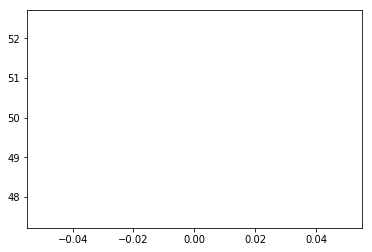

In [35]:
learningrate=0.01
L_Erms_Val   = []  #For each epoch we calculate t,v,t error
L_Erms_TR    = []
L_Erms_Test  = [] 
L_Accu_TR = []
L_Accu_Val=[]
L_Accu_Test=[]
def sigmoid(X): #sigmoid function
    return 1.0/(1+np.exp(-X))
    #print(type(1.0/(1+np.exp(-X))))

def gradient(theta,X,Y):
    theta=np.matrix(theta)
    x=np.matrix(X)
    y=np.matrix(Y)
    
    parameters=int(theta.ravel().shape[1])
    grad=np.zeros(parameters)
    
    error=sigmoid(np.dot(x,theta.T))-y#T
    error=np.array(np.array(error.T)[0].tolist())
        
    for i in range(parameters):
        grad=np.dot(error,x[:,i])
    return grad

#convert to numpy arrays
X=np.array(pd.read_csv(r'C:\Users\Administrator\Desktop\Humansubtractfeatures.csv').values)##np.array(X.values)  np.array(.values)
Y=np.array(pd.read_csv(r'C:\Users\Administrator\Desktop\concatenationtargets.csv').values)##np.array(y.values
#Initalize the parameter array theta
theta_now=np.zeros(9)#every pair's features
#print(theta_now)
#print(X)
#print(Y)
def predict(theta,X):
    #print(X*theta.T)
    newdot=np.dot(X,theta.T)
    #print(newdot)
    probability=sigmoid(np.dot(X,theta.T))#T
    #print(probability)
    #newData=np.zeros((len(probability),1))
   # for i in range(0,len(probability)):
        #if probability[i,0]>=0.5:
            #newData[i,0]==1
        #else :
           # newData[i,0]==0
    #Tprobability=np.transpose(probability)
    #print(len(Tprobability))
    #print(newData)
    #return newData
    probability[probability>=0.5]=1
    probability[probability<0.5]=0
    #print(probability)
    return probability

def GetLErms(VAL_TEST_OUT,ValDataAct):
    sum = 0
    t=0
    #accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i,0] - VAL_TEST_OUT[i,0]),2)  #square error
        if(VAL_TEST_OUT[i,0]== ValDataAct[i,0]):
            counter+=1  #correct prediction and increment 
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))###counter*100
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

def TrainingMatrix(Data):
    newData=np.zeros((round(0.8*len(Data)),1))
    #newData=np.transpose(ewData)
    #print(type(newData))
    for i in range(0,round(0.8*len(Data))):
        newData[i,0]=Data[i,0]
    #print(len(Data))
    return newData
    
def ValidationMatrix(Data):
    newData=np.zeros((round(0.9*len(Data))-round(0.8*len(Data)),1))
    #newData=np.transpose(ewData)
    for i in range(round(0.8*len(Data)),round(0.9*len(Data))):
        newData[(i-round(0.8*len(Data))),0]=Data[i,0]
    return newData

def TestingMatrix(Data):
    newData=np.zeros((len(Data)-round(0.9*len(Data)),1))
    #newData=np.transpose(ewData)
    for i in range(round(0.9*len(Data)),len(Data)):
        newData[(i-round(0.9*len(Data))),0]=Data[i,0]
    return newData
        
Trainingtarget=TrainingMatrix(Y)
ValdataAct=ValidationMatrix(Y)
TestdataAct=TestingMatrix(Y)

#print(Trainingtarget)
#print(ValdataAct)
#print(TestdataAct)
for epochs in range(100):
    #printf("cost fot "+str(epochs)+"epoch:"+str(cost(theta_now,X,y)))
    delta_theta=gradient(theta_now,X,Y)
   #print(delta_theta)
    theta_next=theta_now-(learningrate*delta_theta)
    theta_now=theta_next
    #print(theta_now)
    theta_min=np.array(theta_now)
    #print(theta_min)
    #probability=predict(theta_min,X)
    #-----------------TrainingData Erms---------------------#
    #print(predict(theta_min,X))
    TR_TEST_OUT   = TrainingMatrix(predict(theta_min,X))#GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetLErms(TR_TEST_OUT,Trainingtarget)
    #print(Erms_TR)
    #print(Trainingtarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    L_Accu_TR.append(float(Erms_TR.split(',')[0]))
    
    #-----------------ValidationData Erms---------------------#
    VAL_TEST_OUT  = ValidationMatrix(predict(theta_min,X))#GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetLErms(VAL_TEST_OUT,ValdataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))  #change 1 to 0,original is 1
    L_Accu_Val.append(float(Erms_Val.split(',')[0]))
    
    #-----------------TestingData Erms---------------------#
    TEST_OUT      = TestingMatrix(predict(theta_min,X))#GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetLErms(TEST_OUT,TestdataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))
    L_Accu_Test.append(float(Erms_Test.split(',')[0]))

def averageaccuracy(Data):
    sum=0.0
    for i in range(len(Data)):
        sum+=Data[i]
    averageaccuracy=sum/len(Data)
    return averageaccuracy 

TrainingAccuracy   = str(GetLErms(TR_TEST_OUT,Trainingtarget))
ValidationAccuracy = str(GetLErms(VAL_TEST_OUT,ValdataAct))
TestAccuracy       = str(GetLErms(TEST_OUT,TestdataAct))
print('TRaverageaccuracy=',averageaccuracy(L_Accu_TR))
print('Valaverageaccuracy=',averageaccuracy(L_Accu_Val))
print('Testaverageaccuracy=',averageaccuracy(L_Accu_Test))

#print ("Training accuracy  = " +str(float(TrainingAccuracy.split(',')[0])))  #0,accuracy
#print ("Validation accuracy= " +str(float(ValidationAccuracy.split(',')[0])))  
#print ("Testing accuracy   = " +str(float(TestAccuracy.split(',')[0])))  
print ("Training accuracy  = " +str(np.around(max(L_Accu_TR),5)))
print ("Validation accuracy= " +str(np.around(max(L_Accu_Val),5)))  
print ("Testing accuracy   = " +str(np.around(max(L_Accu_Test),5))) 

print ('----------Gradient Descent Solution--------------------')
#print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(max(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(max(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(max(L_Erms_Test),5)))

import matplotlib as plt
pd.Series(float(np.around(max(L_Accu_TR),5))).plot()
plt.show()

# Neural network

In [36]:
from keras.models import Sequential
from keras.layers import Dense
#import numpy as np
import pandas as pd
#seed=7 
#np.random.seed(seed)

#X= pd.read_csv(r'C:\Users\Administrator\Desktop\concatenationfeatures.csv')
#Y= pd.read_csv(r'C:\Users\Administrator\Desktop\concatenationtargets.csv')

X= pd.read_csv(r'C:\Users\Administrator\Desktop\Humansubtractfeatures.csv')
Y= pd.read_csv(r'C:\Users\Administrator\Desktop\concatenationtargets.csv')
#create model
model=Sequential()
model.add(Dense(9,input_dim=9,init='uniform',activation='relu'))   #18 10 4 1#1024 512 64 1#512 128 16 1
model.add(Dense(5,init='uniform',activation='relu'))
model.add(Dense(2,init='uniform',activation='tanh'))
model.add(Dense(1,init='uniform',activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, nb_epoch=40000, batch_size=200,  verbose=2)
predictions = model.predict(X)

#rounded = [round(x) for x in predictions]
#print(rounded)

D:\PYTHON\lingshi\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, input_dim=9, activation="relu", kernel_initializer="uniform")`
  from ipykernel import kernelapp as app
D:\PYTHON\lingshi\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="uniform")`
  app.launch_new_instance()
D:\PYTHON\lingshi\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="tanh", kernel_initializer="uniform")`
D:\PYTHON\lingshi\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
D:\PYTHON\lingshi\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/40000
 - 1s - loss: 0.6931 - acc: 0.5189
Epoch 2/40000
 - 0s - loss: 0.6930 - acc: 0.5267
Epoch 3/40000
 - 0s - loss: 0.6929 - acc: 0.5267
Epoch 4/40000
 - 0s - loss: 0.6927 - acc: 0.5267
Epoch 5/40000
 - 0s - loss: 0.6927 - acc: 0.5267
Epoch 6/40000
 - 0s - loss: 0.6926 - acc: 0.5267
Epoch 7/40000
 - 0s - loss: 0.6925 - acc: 0.5267
Epoch 8/40000
 - 0s - loss: 0.6924 - acc: 0.5267
Epoch 9/40000
 - 0s - loss: 0.6923 - acc: 0.5267
Epoch 10/40000
 - 0s - loss: 0.6923 - acc: 0.5267
Epoch 11/40000
 - 0s - loss: 0.6922 - acc: 0.5267
Epoch 12/40000
 - 0s - loss: 0.6921 - acc: 0.5267
Epoch 13/40000
 - 0s - loss: 0.6921 - acc: 0.5267
Epoch 14/40000
 - 0s - loss: 0.6919 - acc: 0.5267
Epoch 15/40000
 - 0s - loss: 0.6918 - acc: 0.5267
Epoch 16/40000
 - 0s - loss: 0.6917 - acc: 0.5267
Epoch 17/40000
 - 0s - loss: 0.6916 - acc: 0.5267
Epoch 18/40000
 - 0s - loss: 0.6915 - acc: 0.5267
Epoch 19/40000
 - 0s - loss: 0.6913 - acc: 0.5267
Epoch 20/40000
 - 0s - loss: 0.6911 - acc: 0.5267
Epoch 21/

Epoch 164/40000
 - 0s - loss: 0.6639 - acc: 0.6105
Epoch 165/40000
 - 0s - loss: 0.6638 - acc: 0.6058
Epoch 166/40000
 - 0s - loss: 0.6635 - acc: 0.6087
Epoch 167/40000
 - 0s - loss: 0.6636 - acc: 0.6028
Epoch 168/40000
 - 0s - loss: 0.6636 - acc: 0.6064
Epoch 169/40000
 - 0s - loss: 0.6635 - acc: 0.6087
Epoch 170/40000
 - 0s - loss: 0.6633 - acc: 0.6064
Epoch 171/40000
 - 0s - loss: 0.6634 - acc: 0.6064
Epoch 172/40000
 - 0s - loss: 0.6631 - acc: 0.6010
Epoch 173/40000
 - 0s - loss: 0.6632 - acc: 0.6016
Epoch 174/40000
 - 0s - loss: 0.6630 - acc: 0.6064
Epoch 175/40000
 - 0s - loss: 0.6629 - acc: 0.6040
Epoch 176/40000
 - 0s - loss: 0.6630 - acc: 0.6034
Epoch 177/40000
 - 0s - loss: 0.6628 - acc: 0.6040
Epoch 178/40000
 - 0s - loss: 0.6630 - acc: 0.6070
Epoch 179/40000
 - 0s - loss: 0.6627 - acc: 0.6058
Epoch 180/40000
 - 0s - loss: 0.6628 - acc: 0.6099
Epoch 181/40000
 - 0s - loss: 0.6629 - acc: 0.6081
Epoch 182/40000
 - 0s - loss: 0.6624 - acc: 0.6046
Epoch 183/40000
 - 0s - loss: 0

Epoch 325/40000
 - 0s - loss: 0.6520 - acc: 0.6195
Epoch 326/40000
 - 0s - loss: 0.6519 - acc: 0.6135
Epoch 327/40000
 - 0s - loss: 0.6522 - acc: 0.6153
Epoch 328/40000
 - 0s - loss: 0.6519 - acc: 0.6177
Epoch 329/40000
 - 0s - loss: 0.6516 - acc: 0.6171
Epoch 330/40000
 - 0s - loss: 0.6517 - acc: 0.6123
Epoch 331/40000
 - 0s - loss: 0.6516 - acc: 0.6153
Epoch 332/40000
 - 0s - loss: 0.6515 - acc: 0.6171
Epoch 333/40000
 - 0s - loss: 0.6516 - acc: 0.6117
Epoch 334/40000
 - 0s - loss: 0.6512 - acc: 0.6135
Epoch 335/40000
 - 0s - loss: 0.6512 - acc: 0.6171
Epoch 336/40000
 - 0s - loss: 0.6511 - acc: 0.6195
Epoch 337/40000
 - 0s - loss: 0.6513 - acc: 0.6195
Epoch 338/40000
 - 0s - loss: 0.6514 - acc: 0.6189
Epoch 339/40000
 - 0s - loss: 0.6510 - acc: 0.6225
Epoch 340/40000
 - 0s - loss: 0.6507 - acc: 0.6153
Epoch 341/40000
 - 0s - loss: 0.6508 - acc: 0.6159
Epoch 342/40000
 - 0s - loss: 0.6505 - acc: 0.6183
Epoch 343/40000
 - 0s - loss: 0.6507 - acc: 0.6201
Epoch 344/40000
 - 0s - loss: 0

Epoch 486/40000
 - 0s - loss: 0.6426 - acc: 0.6339
Epoch 487/40000
 - 0s - loss: 0.6426 - acc: 0.6339
Epoch 488/40000
 - 0s - loss: 0.6426 - acc: 0.6309
Epoch 489/40000
 - 0s - loss: 0.6423 - acc: 0.6351
Epoch 490/40000
 - 0s - loss: 0.6423 - acc: 0.6351
Epoch 491/40000
 - 0s - loss: 0.6420 - acc: 0.6327
Epoch 492/40000
 - 0s - loss: 0.6421 - acc: 0.6303
Epoch 493/40000
 - 0s - loss: 0.6421 - acc: 0.6363
Epoch 494/40000
 - 0s - loss: 0.6418 - acc: 0.6387
Epoch 495/40000
 - 0s - loss: 0.6421 - acc: 0.6351
Epoch 496/40000
 - 0s - loss: 0.6419 - acc: 0.6309
Epoch 497/40000
 - 0s - loss: 0.6421 - acc: 0.6369
Epoch 498/40000
 - 0s - loss: 0.6417 - acc: 0.6369
Epoch 499/40000
 - 0s - loss: 0.6419 - acc: 0.6357
Epoch 500/40000
 - 0s - loss: 0.6415 - acc: 0.6369
Epoch 501/40000
 - 0s - loss: 0.6416 - acc: 0.6363
Epoch 502/40000
 - 0s - loss: 0.6415 - acc: 0.6387
Epoch 503/40000
 - 0s - loss: 0.6419 - acc: 0.6351
Epoch 504/40000
 - 0s - loss: 0.6417 - acc: 0.6339
Epoch 505/40000
 - 0s - loss: 0

Epoch 647/40000
 - 0s - loss: 0.6299 - acc: 0.6423
Epoch 648/40000
 - 0s - loss: 0.6295 - acc: 0.6405
Epoch 649/40000
 - 0s - loss: 0.6297 - acc: 0.6441
Epoch 650/40000
 - 0s - loss: 0.6296 - acc: 0.6411
Epoch 651/40000
 - 0s - loss: 0.6294 - acc: 0.6417
Epoch 652/40000
 - 0s - loss: 0.6295 - acc: 0.6471
Epoch 653/40000
 - 0s - loss: 0.6291 - acc: 0.6429
Epoch 654/40000
 - 0s - loss: 0.6290 - acc: 0.6441
Epoch 655/40000
 - 0s - loss: 0.6291 - acc: 0.6447
Epoch 656/40000
 - 0s - loss: 0.6295 - acc: 0.6405
Epoch 657/40000
 - 0s - loss: 0.6289 - acc: 0.6453
Epoch 658/40000
 - 0s - loss: 0.6290 - acc: 0.6447
Epoch 659/40000
 - 0s - loss: 0.6292 - acc: 0.6501
Epoch 660/40000
 - 0s - loss: 0.6287 - acc: 0.6441
Epoch 661/40000
 - 0s - loss: 0.6285 - acc: 0.6459
Epoch 662/40000
 - 0s - loss: 0.6293 - acc: 0.6447
Epoch 663/40000
 - 0s - loss: 0.6288 - acc: 0.6465
Epoch 664/40000
 - 0s - loss: 0.6286 - acc: 0.6447
Epoch 665/40000
 - 0s - loss: 0.6287 - acc: 0.6429
Epoch 666/40000
 - 0s - loss: 0

Epoch 808/40000
 - 0s - loss: 0.6228 - acc: 0.6543
Epoch 809/40000
 - 0s - loss: 0.6220 - acc: 0.6483
Epoch 810/40000
 - 0s - loss: 0.6221 - acc: 0.6477
Epoch 811/40000
 - 0s - loss: 0.6220 - acc: 0.6501
Epoch 812/40000
 - 0s - loss: 0.6228 - acc: 0.6519
Epoch 813/40000
 - 0s - loss: 0.6219 - acc: 0.6561
Epoch 814/40000
 - 0s - loss: 0.6225 - acc: 0.6495
Epoch 815/40000
 - 0s - loss: 0.6219 - acc: 0.6465
Epoch 816/40000
 - 0s - loss: 0.6220 - acc: 0.6495
Epoch 817/40000
 - 0s - loss: 0.6216 - acc: 0.6525
Epoch 818/40000
 - 0s - loss: 0.6223 - acc: 0.6465
Epoch 819/40000
 - 0s - loss: 0.6217 - acc: 0.6507
Epoch 820/40000
 - 0s - loss: 0.6218 - acc: 0.6525
Epoch 821/40000
 - 0s - loss: 0.6214 - acc: 0.6465
Epoch 822/40000
 - 0s - loss: 0.6220 - acc: 0.6501
Epoch 823/40000
 - 0s - loss: 0.6220 - acc: 0.6471
Epoch 824/40000
 - 0s - loss: 0.6217 - acc: 0.6513
Epoch 825/40000
 - 0s - loss: 0.6230 - acc: 0.6519
Epoch 826/40000
 - 0s - loss: 0.6218 - acc: 0.6513
Epoch 827/40000
 - 0s - loss: 0

Epoch 969/40000
 - 0s - loss: 0.6179 - acc: 0.6573
Epoch 970/40000
 - 0s - loss: 0.6183 - acc: 0.6555
Epoch 971/40000
 - 0s - loss: 0.6183 - acc: 0.6501
Epoch 972/40000
 - 0s - loss: 0.6181 - acc: 0.6555
Epoch 973/40000
 - 0s - loss: 0.6178 - acc: 0.6525
Epoch 974/40000
 - 0s - loss: 0.6186 - acc: 0.6537
Epoch 975/40000
 - 0s - loss: 0.6185 - acc: 0.6567
Epoch 976/40000
 - 0s - loss: 0.6188 - acc: 0.6525
Epoch 977/40000
 - 0s - loss: 0.6183 - acc: 0.6519
Epoch 978/40000
 - 0s - loss: 0.6183 - acc: 0.6621
Epoch 979/40000
 - 0s - loss: 0.6189 - acc: 0.6537
Epoch 980/40000
 - 0s - loss: 0.6177 - acc: 0.6519
Epoch 981/40000
 - 0s - loss: 0.6185 - acc: 0.6501
Epoch 982/40000
 - 0s - loss: 0.6179 - acc: 0.6519
Epoch 983/40000
 - 0s - loss: 0.6181 - acc: 0.6549
Epoch 984/40000
 - 0s - loss: 0.6176 - acc: 0.6615
Epoch 985/40000
 - 0s - loss: 0.6184 - acc: 0.6543
Epoch 986/40000
 - 0s - loss: 0.6183 - acc: 0.6519
Epoch 987/40000
 - 0s - loss: 0.6176 - acc: 0.6531
Epoch 988/40000
 - 0s - loss: 0

Epoch 1128/40000
 - 0s - loss: 0.6149 - acc: 0.6543
Epoch 1129/40000
 - 0s - loss: 0.6152 - acc: 0.6537
Epoch 1130/40000
 - 0s - loss: 0.6150 - acc: 0.6579
Epoch 1131/40000
 - 0s - loss: 0.6147 - acc: 0.6621
Epoch 1132/40000
 - 0s - loss: 0.6149 - acc: 0.6579
Epoch 1133/40000
 - 0s - loss: 0.6148 - acc: 0.6561
Epoch 1134/40000
 - 0s - loss: 0.6155 - acc: 0.6543
Epoch 1135/40000
 - 0s - loss: 0.6154 - acc: 0.6591
Epoch 1136/40000
 - 0s - loss: 0.6150 - acc: 0.6579
Epoch 1137/40000
 - 0s - loss: 0.6153 - acc: 0.6585
Epoch 1138/40000
 - 0s - loss: 0.6167 - acc: 0.6585
Epoch 1139/40000
 - 0s - loss: 0.6149 - acc: 0.6603
Epoch 1140/40000
 - 0s - loss: 0.6152 - acc: 0.6561
Epoch 1141/40000
 - 0s - loss: 0.6145 - acc: 0.6597
Epoch 1142/40000
 - 0s - loss: 0.6153 - acc: 0.6501
Epoch 1143/40000
 - 0s - loss: 0.6152 - acc: 0.6531
Epoch 1144/40000
 - 0s - loss: 0.6150 - acc: 0.6549
Epoch 1145/40000
 - 0s - loss: 0.6148 - acc: 0.6567
Epoch 1146/40000
 - 0s - loss: 0.6148 - acc: 0.6567
Epoch 1147/4

Epoch 1286/40000
 - 0s - loss: 0.6129 - acc: 0.6555
Epoch 1287/40000
 - 0s - loss: 0.6130 - acc: 0.6615
Epoch 1288/40000
 - 0s - loss: 0.6128 - acc: 0.6639
Epoch 1289/40000
 - 0s - loss: 0.6129 - acc: 0.6615
Epoch 1290/40000
 - 0s - loss: 0.6128 - acc: 0.6531
Epoch 1291/40000
 - 0s - loss: 0.6132 - acc: 0.6591
Epoch 1292/40000
 - 0s - loss: 0.6129 - acc: 0.6531
Epoch 1293/40000
 - 0s - loss: 0.6129 - acc: 0.6573
Epoch 1294/40000
 - 0s - loss: 0.6127 - acc: 0.6633
Epoch 1295/40000
 - 0s - loss: 0.6124 - acc: 0.6639
Epoch 1296/40000
 - 0s - loss: 0.6133 - acc: 0.6549
Epoch 1297/40000
 - 0s - loss: 0.6126 - acc: 0.6585
Epoch 1298/40000
 - 0s - loss: 0.6126 - acc: 0.6639
Epoch 1299/40000
 - 0s - loss: 0.6128 - acc: 0.6669
Epoch 1300/40000
 - 0s - loss: 0.6128 - acc: 0.6621
Epoch 1301/40000
 - 0s - loss: 0.6129 - acc: 0.6609
Epoch 1302/40000
 - 0s - loss: 0.6125 - acc: 0.6627
Epoch 1303/40000
 - 0s - loss: 0.6122 - acc: 0.6561
Epoch 1304/40000
 - 0s - loss: 0.6128 - acc: 0.6573
Epoch 1305/4

Epoch 1444/40000
 - 0s - loss: 0.6108 - acc: 0.6591
Epoch 1445/40000
 - 0s - loss: 0.6111 - acc: 0.6591
Epoch 1446/40000
 - 0s - loss: 0.6113 - acc: 0.6579
Epoch 1447/40000
 - 0s - loss: 0.6111 - acc: 0.6585
Epoch 1448/40000
 - 0s - loss: 0.6110 - acc: 0.6639
Epoch 1449/40000
 - 0s - loss: 0.6112 - acc: 0.6609
Epoch 1450/40000
 - 0s - loss: 0.6112 - acc: 0.6585
Epoch 1451/40000
 - 0s - loss: 0.6110 - acc: 0.6573
Epoch 1452/40000
 - 0s - loss: 0.6110 - acc: 0.6597
Epoch 1453/40000
 - 0s - loss: 0.6113 - acc: 0.6591
Epoch 1454/40000
 - 0s - loss: 0.6117 - acc: 0.6555
Epoch 1455/40000
 - 0s - loss: 0.6104 - acc: 0.6561
Epoch 1456/40000
 - 0s - loss: 0.6109 - acc: 0.6609
Epoch 1457/40000
 - 0s - loss: 0.6118 - acc: 0.6579
Epoch 1458/40000
 - 0s - loss: 0.6105 - acc: 0.6633
Epoch 1459/40000
 - 0s - loss: 0.6114 - acc: 0.6633
Epoch 1460/40000
 - 0s - loss: 0.6106 - acc: 0.6591
Epoch 1461/40000
 - 0s - loss: 0.6111 - acc: 0.6687
Epoch 1462/40000
 - 0s - loss: 0.6114 - acc: 0.6561
Epoch 1463/4

Epoch 1602/40000
 - 0s - loss: 0.6114 - acc: 0.6687
Epoch 1603/40000
 - 0s - loss: 0.6097 - acc: 0.6621
Epoch 1604/40000
 - 0s - loss: 0.6096 - acc: 0.6633
Epoch 1605/40000
 - 0s - loss: 0.6093 - acc: 0.6627
Epoch 1606/40000
 - 0s - loss: 0.6097 - acc: 0.6651
Epoch 1607/40000
 - 0s - loss: 0.6102 - acc: 0.6603
Epoch 1608/40000
 - 0s - loss: 0.6104 - acc: 0.6699
Epoch 1609/40000
 - 0s - loss: 0.6100 - acc: 0.6615
Epoch 1610/40000
 - 0s - loss: 0.6097 - acc: 0.6627
Epoch 1611/40000
 - 0s - loss: 0.6094 - acc: 0.6597
Epoch 1612/40000
 - 0s - loss: 0.6097 - acc: 0.6633
Epoch 1613/40000
 - 0s - loss: 0.6098 - acc: 0.6639
Epoch 1614/40000
 - 0s - loss: 0.6104 - acc: 0.6633
Epoch 1615/40000
 - 0s - loss: 0.6094 - acc: 0.6657
Epoch 1616/40000
 - 0s - loss: 0.6104 - acc: 0.6585
Epoch 1617/40000
 - 0s - loss: 0.6086 - acc: 0.6645
Epoch 1618/40000
 - 0s - loss: 0.6105 - acc: 0.6639
Epoch 1619/40000
 - 0s - loss: 0.6097 - acc: 0.6597
Epoch 1620/40000
 - 0s - loss: 0.6095 - acc: 0.6627
Epoch 1621/4

Epoch 1760/40000
 - 0s - loss: 0.6093 - acc: 0.6681
Epoch 1761/40000
 - 0s - loss: 0.6089 - acc: 0.6651
Epoch 1762/40000
 - 0s - loss: 0.6083 - acc: 0.6639
Epoch 1763/40000
 - 0s - loss: 0.6081 - acc: 0.6675
Epoch 1764/40000
 - 0s - loss: 0.6089 - acc: 0.6621
Epoch 1765/40000
 - 0s - loss: 0.6094 - acc: 0.6597
Epoch 1766/40000
 - 0s - loss: 0.6085 - acc: 0.6663
Epoch 1767/40000
 - 0s - loss: 0.6085 - acc: 0.6699
Epoch 1768/40000
 - 0s - loss: 0.6082 - acc: 0.6687
Epoch 1769/40000
 - 0s - loss: 0.6080 - acc: 0.6651
Epoch 1770/40000
 - 0s - loss: 0.6088 - acc: 0.6669
Epoch 1771/40000
 - 0s - loss: 0.6089 - acc: 0.6711
Epoch 1772/40000
 - 0s - loss: 0.6091 - acc: 0.6645
Epoch 1773/40000
 - 0s - loss: 0.6085 - acc: 0.6645
Epoch 1774/40000
 - 0s - loss: 0.6092 - acc: 0.6651
Epoch 1775/40000
 - 0s - loss: 0.6093 - acc: 0.6663
Epoch 1776/40000
 - 0s - loss: 0.6090 - acc: 0.6603
Epoch 1777/40000
 - 0s - loss: 0.6084 - acc: 0.6633
Epoch 1778/40000
 - 0s - loss: 0.6084 - acc: 0.6621
Epoch 1779/4

Epoch 1918/40000
 - 0s - loss: 0.6057 - acc: 0.6645
Epoch 1919/40000
 - 0s - loss: 0.6062 - acc: 0.6681
Epoch 1920/40000
 - 0s - loss: 0.6060 - acc: 0.6669
Epoch 1921/40000
 - 0s - loss: 0.6057 - acc: 0.6681
Epoch 1922/40000
 - 0s - loss: 0.6059 - acc: 0.6681
Epoch 1923/40000
 - 0s - loss: 0.6070 - acc: 0.6681
Epoch 1924/40000
 - 0s - loss: 0.6057 - acc: 0.6681
Epoch 1925/40000
 - 0s - loss: 0.6072 - acc: 0.6663
Epoch 1926/40000
 - 0s - loss: 0.6076 - acc: 0.6609
Epoch 1927/40000
 - 0s - loss: 0.6058 - acc: 0.6657
Epoch 1928/40000
 - 0s - loss: 0.6060 - acc: 0.6639
Epoch 1929/40000
 - 0s - loss: 0.6063 - acc: 0.6651
Epoch 1930/40000
 - 0s - loss: 0.6061 - acc: 0.6675
Epoch 1931/40000
 - 0s - loss: 0.6068 - acc: 0.6651
Epoch 1932/40000
 - 0s - loss: 0.6067 - acc: 0.6699
Epoch 1933/40000
 - 0s - loss: 0.6061 - acc: 0.6735
Epoch 1934/40000
 - 0s - loss: 0.6056 - acc: 0.6717
Epoch 1935/40000
 - 0s - loss: 0.6056 - acc: 0.6699
Epoch 1936/40000
 - 0s - loss: 0.6057 - acc: 0.6729
Epoch 1937/4

Epoch 2076/40000
 - 0s - loss: 0.6030 - acc: 0.6794
Epoch 2077/40000
 - 0s - loss: 0.6035 - acc: 0.6777
Epoch 2078/40000
 - 0s - loss: 0.6035 - acc: 0.6777
Epoch 2079/40000
 - 0s - loss: 0.6046 - acc: 0.6723
Epoch 2080/40000
 - 0s - loss: 0.6032 - acc: 0.6693
Epoch 2081/40000
 - 0s - loss: 0.6029 - acc: 0.6711
Epoch 2082/40000
 - 0s - loss: 0.6037 - acc: 0.6735
Epoch 2083/40000
 - 0s - loss: 0.6036 - acc: 0.6717
Epoch 2084/40000
 - 0s - loss: 0.6038 - acc: 0.6723
Epoch 2085/40000
 - 0s - loss: 0.6030 - acc: 0.6717
Epoch 2086/40000
 - 0s - loss: 0.6032 - acc: 0.6735
Epoch 2087/40000
 - 0s - loss: 0.6033 - acc: 0.6759
Epoch 2088/40000
 - 0s - loss: 0.6027 - acc: 0.6765
Epoch 2089/40000
 - 0s - loss: 0.6032 - acc: 0.6759
Epoch 2090/40000
 - 0s - loss: 0.6027 - acc: 0.6747
Epoch 2091/40000
 - 0s - loss: 0.6027 - acc: 0.6759
Epoch 2092/40000
 - 0s - loss: 0.6029 - acc: 0.6777
Epoch 2093/40000
 - 0s - loss: 0.6026 - acc: 0.6771
Epoch 2094/40000
 - 0s - loss: 0.6032 - acc: 0.6771
Epoch 2095/4

Epoch 2234/40000
 - 0s - loss: 0.6002 - acc: 0.6771
Epoch 2235/40000
 - 0s - loss: 0.6003 - acc: 0.6777
Epoch 2236/40000
 - 0s - loss: 0.6007 - acc: 0.6705
Epoch 2237/40000
 - 0s - loss: 0.6013 - acc: 0.6747
Epoch 2238/40000
 - 0s - loss: 0.6005 - acc: 0.6729
Epoch 2239/40000
 - 0s - loss: 0.6008 - acc: 0.6693
Epoch 2240/40000
 - 0s - loss: 0.6012 - acc: 0.6759
Epoch 2241/40000
 - 0s - loss: 0.6008 - acc: 0.6788
Epoch 2242/40000
 - 0s - loss: 0.6000 - acc: 0.6794
Epoch 2243/40000
 - 0s - loss: 0.6008 - acc: 0.6741
Epoch 2244/40000
 - 0s - loss: 0.6004 - acc: 0.6723
Epoch 2245/40000
 - 0s - loss: 0.6002 - acc: 0.6723
Epoch 2246/40000
 - 0s - loss: 0.6005 - acc: 0.6705
Epoch 2247/40000
 - 0s - loss: 0.6000 - acc: 0.6705
Epoch 2248/40000
 - 0s - loss: 0.6004 - acc: 0.6711
Epoch 2249/40000
 - 0s - loss: 0.6002 - acc: 0.6800
Epoch 2250/40000
 - 0s - loss: 0.5997 - acc: 0.6765
Epoch 2251/40000
 - 0s - loss: 0.5997 - acc: 0.6723
Epoch 2252/40000
 - 0s - loss: 0.5998 - acc: 0.6794
Epoch 2253/4

Epoch 2392/40000
 - 0s - loss: 0.5997 - acc: 0.6765
Epoch 2393/40000
 - 0s - loss: 0.5993 - acc: 0.6812
Epoch 2394/40000
 - 0s - loss: 0.5981 - acc: 0.6777
Epoch 2395/40000
 - 0s - loss: 0.5986 - acc: 0.6759
Epoch 2396/40000
 - 0s - loss: 0.5987 - acc: 0.6753
Epoch 2397/40000
 - 0s - loss: 0.5987 - acc: 0.6788
Epoch 2398/40000
 - 0s - loss: 0.5981 - acc: 0.6818
Epoch 2399/40000
 - 0s - loss: 0.5986 - acc: 0.6723
Epoch 2400/40000
 - 0s - loss: 0.5993 - acc: 0.6759
Epoch 2401/40000
 - 0s - loss: 0.5995 - acc: 0.6735
Epoch 2402/40000
 - 0s - loss: 0.5979 - acc: 0.6783
Epoch 2403/40000
 - 0s - loss: 0.5983 - acc: 0.6711
Epoch 2404/40000
 - 0s - loss: 0.5986 - acc: 0.6735
Epoch 2405/40000
 - 0s - loss: 0.5980 - acc: 0.6783
Epoch 2406/40000
 - 0s - loss: 0.5985 - acc: 0.6800
Epoch 2407/40000
 - 0s - loss: 0.6000 - acc: 0.6765
Epoch 2408/40000
 - 0s - loss: 0.5983 - acc: 0.6800
Epoch 2409/40000
 - 0s - loss: 0.5982 - acc: 0.6717
Epoch 2410/40000
 - 0s - loss: 0.5986 - acc: 0.6735
Epoch 2411/4

Epoch 2550/40000
 - 0s - loss: 0.5987 - acc: 0.6753
Epoch 2551/40000
 - 0s - loss: 0.5978 - acc: 0.6747
Epoch 2552/40000
 - 0s - loss: 0.5974 - acc: 0.6753
Epoch 2553/40000
 - 0s - loss: 0.5975 - acc: 0.6753
Epoch 2554/40000
 - 0s - loss: 0.5977 - acc: 0.6711
Epoch 2555/40000
 - 0s - loss: 0.5981 - acc: 0.6687
Epoch 2556/40000
 - 0s - loss: 0.5981 - acc: 0.6777
Epoch 2557/40000
 - 0s - loss: 0.5975 - acc: 0.6759
Epoch 2558/40000
 - 0s - loss: 0.5975 - acc: 0.6711
Epoch 2559/40000
 - 0s - loss: 0.5975 - acc: 0.6699
Epoch 2560/40000
 - 0s - loss: 0.5980 - acc: 0.6693
Epoch 2561/40000
 - 0s - loss: 0.5976 - acc: 0.6741
Epoch 2562/40000
 - 0s - loss: 0.5974 - acc: 0.6723
Epoch 2563/40000
 - 0s - loss: 0.5977 - acc: 0.6693
Epoch 2564/40000
 - 0s - loss: 0.5985 - acc: 0.6729
Epoch 2565/40000
 - 0s - loss: 0.5980 - acc: 0.6759
Epoch 2566/40000
 - 0s - loss: 0.5979 - acc: 0.6747
Epoch 2567/40000
 - 0s - loss: 0.5971 - acc: 0.6788
Epoch 2568/40000
 - 0s - loss: 0.5983 - acc: 0.6818
Epoch 2569/4

Epoch 2708/40000
 - 0s - loss: 0.5972 - acc: 0.6765
Epoch 2709/40000
 - 0s - loss: 0.5978 - acc: 0.6699
Epoch 2710/40000
 - 0s - loss: 0.5966 - acc: 0.6735
Epoch 2711/40000
 - 0s - loss: 0.5966 - acc: 0.6741
Epoch 2712/40000
 - 0s - loss: 0.5964 - acc: 0.6765
Epoch 2713/40000
 - 0s - loss: 0.5973 - acc: 0.6747
Epoch 2714/40000
 - 0s - loss: 0.5981 - acc: 0.6735
Epoch 2715/40000
 - 0s - loss: 0.5972 - acc: 0.6759
Epoch 2716/40000
 - 0s - loss: 0.5965 - acc: 0.6729
Epoch 2717/40000
 - 0s - loss: 0.5972 - acc: 0.6729
Epoch 2718/40000
 - 0s - loss: 0.5970 - acc: 0.6735
Epoch 2719/40000
 - 0s - loss: 0.5968 - acc: 0.6759
Epoch 2720/40000
 - 0s - loss: 0.5989 - acc: 0.6699
Epoch 2721/40000
 - 0s - loss: 0.5986 - acc: 0.6699
Epoch 2722/40000
 - 0s - loss: 0.5970 - acc: 0.6759
Epoch 2723/40000
 - 0s - loss: 0.5976 - acc: 0.6711
Epoch 2724/40000
 - 0s - loss: 0.5976 - acc: 0.6723
Epoch 2725/40000
 - 0s - loss: 0.5978 - acc: 0.6741
Epoch 2726/40000
 - 0s - loss: 0.5972 - acc: 0.6741
Epoch 2727/4

Epoch 2866/40000
 - 0s - loss: 0.5957 - acc: 0.6717
Epoch 2867/40000
 - 0s - loss: 0.5962 - acc: 0.6705
Epoch 2868/40000
 - 0s - loss: 0.5963 - acc: 0.6777
Epoch 2869/40000
 - 0s - loss: 0.5958 - acc: 0.6711
Epoch 2870/40000
 - 0s - loss: 0.5960 - acc: 0.6699
Epoch 2871/40000
 - 0s - loss: 0.5970 - acc: 0.6705
Epoch 2872/40000
 - 0s - loss: 0.5954 - acc: 0.6723
Epoch 2873/40000
 - 0s - loss: 0.5966 - acc: 0.6723
Epoch 2874/40000
 - 0s - loss: 0.5956 - acc: 0.6759
Epoch 2875/40000
 - 0s - loss: 0.5965 - acc: 0.6741
Epoch 2876/40000
 - 0s - loss: 0.5962 - acc: 0.6747
Epoch 2877/40000
 - 0s - loss: 0.5960 - acc: 0.6777
Epoch 2878/40000
 - 0s - loss: 0.5963 - acc: 0.6783
Epoch 2879/40000
 - 0s - loss: 0.5966 - acc: 0.6753
Epoch 2880/40000
 - 0s - loss: 0.5962 - acc: 0.6717
Epoch 2881/40000
 - 0s - loss: 0.5961 - acc: 0.6741
Epoch 2882/40000
 - 0s - loss: 0.5957 - acc: 0.6759
Epoch 2883/40000
 - 0s - loss: 0.5955 - acc: 0.6729
Epoch 2884/40000
 - 0s - loss: 0.5975 - acc: 0.6753
Epoch 2885/4

Epoch 3024/40000
 - 0s - loss: 0.5953 - acc: 0.6741
Epoch 3025/40000
 - 0s - loss: 0.5953 - acc: 0.6747
Epoch 3026/40000
 - 0s - loss: 0.5956 - acc: 0.6759
Epoch 3027/40000
 - 0s - loss: 0.5953 - acc: 0.6765
Epoch 3028/40000
 - 0s - loss: 0.5953 - acc: 0.6777
Epoch 3029/40000
 - 0s - loss: 0.5963 - acc: 0.6759
Epoch 3030/40000
 - 0s - loss: 0.5958 - acc: 0.6747
Epoch 3031/40000
 - 0s - loss: 0.5956 - acc: 0.6783
Epoch 3032/40000
 - 0s - loss: 0.5964 - acc: 0.6693
Epoch 3033/40000
 - 0s - loss: 0.5966 - acc: 0.6741
Epoch 3034/40000
 - 0s - loss: 0.5958 - acc: 0.6759
Epoch 3035/40000
 - 0s - loss: 0.5953 - acc: 0.6741
Epoch 3036/40000
 - 0s - loss: 0.5963 - acc: 0.6729
Epoch 3037/40000
 - 0s - loss: 0.5982 - acc: 0.6741
Epoch 3038/40000
 - 0s - loss: 0.5959 - acc: 0.6729
Epoch 3039/40000
 - 0s - loss: 0.5965 - acc: 0.6741
Epoch 3040/40000
 - 0s - loss: 0.5951 - acc: 0.6765
Epoch 3041/40000
 - 0s - loss: 0.5950 - acc: 0.6723
Epoch 3042/40000
 - 0s - loss: 0.5953 - acc: 0.6747
Epoch 3043/4

Epoch 3182/40000
 - 0s - loss: 0.5951 - acc: 0.6717
Epoch 3183/40000
 - 0s - loss: 0.5947 - acc: 0.6765
Epoch 3184/40000
 - 0s - loss: 0.5949 - acc: 0.6729
Epoch 3185/40000
 - 0s - loss: 0.5947 - acc: 0.6717
Epoch 3186/40000
 - 0s - loss: 0.5965 - acc: 0.6711
Epoch 3187/40000
 - 0s - loss: 0.5955 - acc: 0.6747
Epoch 3188/40000
 - 0s - loss: 0.5948 - acc: 0.6741
Epoch 3189/40000
 - 0s - loss: 0.5950 - acc: 0.6741
Epoch 3190/40000
 - 0s - loss: 0.5950 - acc: 0.6800
Epoch 3191/40000
 - 0s - loss: 0.5950 - acc: 0.6747
Epoch 3192/40000
 - 0s - loss: 0.5956 - acc: 0.6681
Epoch 3193/40000
 - 0s - loss: 0.5951 - acc: 0.6747
Epoch 3194/40000
 - 0s - loss: 0.5950 - acc: 0.6777
Epoch 3195/40000
 - 0s - loss: 0.5954 - acc: 0.6741
Epoch 3196/40000
 - 0s - loss: 0.5954 - acc: 0.6759
Epoch 3197/40000
 - 0s - loss: 0.5950 - acc: 0.6771
Epoch 3198/40000
 - 0s - loss: 0.5959 - acc: 0.6735
Epoch 3199/40000
 - 0s - loss: 0.5952 - acc: 0.6735
Epoch 3200/40000
 - 0s - loss: 0.5954 - acc: 0.6753
Epoch 3201/4

Epoch 3340/40000
 - 0s - loss: 0.5944 - acc: 0.6687
Epoch 3341/40000
 - 0s - loss: 0.5949 - acc: 0.6753
Epoch 3342/40000
 - 0s - loss: 0.5945 - acc: 0.6759
Epoch 3343/40000
 - 0s - loss: 0.5951 - acc: 0.6729
Epoch 3344/40000
 - 0s - loss: 0.5945 - acc: 0.6765
Epoch 3345/40000
 - 0s - loss: 0.5943 - acc: 0.6800
Epoch 3346/40000
 - 0s - loss: 0.5959 - acc: 0.6729
Epoch 3347/40000
 - 0s - loss: 0.5944 - acc: 0.6735
Epoch 3348/40000
 - 0s - loss: 0.5992 - acc: 0.6687
Epoch 3349/40000
 - 0s - loss: 0.5980 - acc: 0.6717
Epoch 3350/40000
 - 0s - loss: 0.5960 - acc: 0.6711
Epoch 3351/40000
 - 0s - loss: 0.5947 - acc: 0.6711
Epoch 3352/40000
 - 0s - loss: 0.5946 - acc: 0.6723
Epoch 3353/40000
 - 0s - loss: 0.5953 - acc: 0.6729
Epoch 3354/40000
 - 0s - loss: 0.5949 - acc: 0.6747
Epoch 3355/40000
 - 0s - loss: 0.5953 - acc: 0.6723
Epoch 3356/40000
 - 0s - loss: 0.5946 - acc: 0.6717
Epoch 3357/40000
 - 0s - loss: 0.5941 - acc: 0.6747
Epoch 3358/40000
 - 0s - loss: 0.5944 - acc: 0.6735
Epoch 3359/4

KeyboardInterrupt: 